## Intduen on AMINER Dataset

* First layer : author-author coauthorship
* Second layer : paper-papar citation
* Third layer : venue-venue citation/similarity

In [1]:
import time
import numpy as np
import scipy.io as scio
from scipy.sparse import lil_matrix,csc_matrix
import matplotlib.pyplot as plt

In [2]:
from src.dataset import Dataset
from src.evaluate import evaluator

## Load and process the dataset
* The adjacency matrix is symmetric and doesn't contain self-loops.
* The multi-layer network is {0,1} valued.

In [4]:
aminer = scio.loadmat('data/Aminer.mat')
dnew = aminer['D_new']
do = aminer['DO']  # the observed cross-layer dependencies
du = aminer['DU']  # the complete cross-layer dependencies
g  = aminer['G']

In [5]:
g1  = g[0][2][0][0][0]    # 61843,61843  coauthorship
g2  = g[0][0][0][0][0]    # 62602,62602  citation
g3  = g[0][1][0][0][0]    # 899,899   venue citation
c12 = du[0][1][0][0][0].T # 61843,62602 author-paper
c23 = du[0][0][0][0][0]   # 62602,899  paper-venue

In [6]:
g1 = g1.tolil()
g2 = g2.tolil()
g3 = g3.tolil()
c12 = c12.tolil()
c23 = c23.tolil()
# Delete self-loops and make the edge weight binary
for i in range(g2.shape[0]):
    g2[i,i] = 0
for i in range(g3.shape[0]):
    g3[i,i] = 0
g1[g1.nonzero()[0],g1.nonzero()[1]] = 1
c12[c12.nonzero()[0],c12.nonzero()[1]] = 1

## Construct the 3-layered network

In [7]:
As  = [g1,g2,g3]
Cs  = dict()
Cs[(0,1)] = c12
Cs[(1,2)] = c23
Cs[(1,0)] = c12.T
Cs[(2,1)] = c23.T
GG = np.array([[0,1,0],[1,0,1],[0,1,0]])
layer = len(As)

## CONF 

In [8]:
from src.utils import *
# convert As and Cs to csc_matrix to accelerate the CONMF
As,Cs = convert_to_csc(As,Cs)
epoch = 50
R = 10

In [9]:
from src.conf import coupled_orthogonal_nmf as CONF
t1 = time.time()
U,lambdaMat,sigmaMat,beta = CONF(As,Cs,GG,None,R,epoch)
t2 = time.time()
print(t2-t1,'s')

9.908988952636719 s


## Intduen on AMINER with BOOST

* $\gamma_{1,2} = 5$
* $\gamma_{2,3} = 5$

In [10]:
from src.induen import INDUEN

In [12]:
gamma = np.ones((3,3))
gamma[0,1] = gamma[1,0] = 5
gamma[1,2] = gamma[2,1] = 5
model = INDUEN(As,Cs,GG,gamma,boost=True)

In [13]:
bestres, best_score, allres = model.run()

After candidating, size of each layer:  [626, 626, 48]
The joint density is 5.1931
After dsd detector, size of each layer:  [28, 0, 0]
The joint density is 13.5000
After neighbor boosting, size of each layer:  [28, 21, 2]
The joint density is 14.4706
The optimal joint density of the 0-th column of factors: 14.4706


After candidating, size of each layer:  [1131, 1526, 57]
The joint density is 9.2553
After dsd detector, size of each layer:  [7, 9, 0]
The joint density is 15.6875
After neighbor boosting, size of each layer:  [8, 10, 0]
The joint density is 15.7778
The optimal joint density of the 1-th column of factors: 0.0000


After candidating, size of each layer:  [626, 626, 39]
The joint density is 5.0821
After dsd detector, size of each layer:  [3, 6, 1]
The joint density is 12.3000
After neighbor boosting, size of each layer:  [3, 10, 1]
The joint density is 13.0714
The optimal joint density of the 2-th column of factors: 13.0714


After candidating, size of each layer:  [898, 741

## Evaluation

In [15]:
from src.evaluate import evaluator
evaluator(As,Cs,GG,bestres)

There are total 5 graphs in this multilayered network.
Size of each layer:  [122, 74, 5]


Edge density of each network: 
Within-layer 1, the edge density is 0.2036
Cross-layer (1, 2), the edge density is 0.02924
Within-layer 2, the edge density is 0.03295
Cross-layer (2, 3), the edge density is 0.1595
Within-layer 3, the edge density is 1


We define some metrics to measure the quality of the dense multilayer subgraph :
Minimum edge density is 0.02924
Geometric average edge density is 0.1256
Arithmetical average edge density is 0.2851
Mixed edge density is 0.2333


(0.02924235711120957,
 0.12562450755706475,
 0.2850567039730627,
 0.23334521374975148)

## Visualization

### Merge and Spy

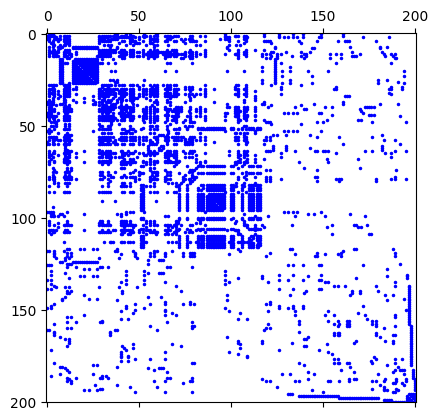

In [17]:
re1,re2,re3 = bestres
tmpas,tmpcs = sample(As,Cs,bestres)
mat,_ = aggregate(tmpas,tmpcs,GG,gamma)
plt.spy(mat,marker='.',markersize=3,color='b')

## 3-layer plot

In [18]:
subgraph1 = bestres[0] # author
subgraph2 = bestres[1] # paper
subgraph3 = bestres[2] # venue
len1 = len(subgraph1)
len2 = len1 + len(subgraph2)
len3 = len2 + len(subgraph3)
dic1 = dict(zip(subgraph1,range(0,len1)))
dic2 = dict(zip(subgraph2,range(len1,len2)))
dic3 = dict(zip(subgraph3,range(len2,len3)))

In [19]:
import networkx as nx
graph = nx.Graph()
len3 = len(re1)+len(re2)+len(re3)
graph.add_nodes_from(list(range(0,len3)))
edge_list = []

In [22]:
As,Cs = convert_to_lil(As,Cs)
for i in subgraph1: # author
    for j in As[0].rows[i]:
        if j in subgraph1:
            graph.add_edge(dic1[i],dic1[j],color="r",linewidths = 1)
for i in subgraph2: # paper
    for j in As[1].rows[i]:
        if j in subgraph2:
            graph.add_edge(dic2[i],dic2[j],color = "b",linewidths = 1)
for i in subgraph3: # venue
    for j in As[2].rows[i]:
        if j in subgraph3:
            graph.add_edge(dic3[i],dic3[j],color = "purple",linewidths = 1)
for i in subgraph1: # author-paper
    for j in subgraph2:
        if Cs[(0,1)][i,j]:
            graph.add_edge(dic1[i],dic2[j],color='#edb120',linewidths = 1)
for i in subgraph2: # paper-venue
    for k in subgraph3:
        if Cs[(1,2)][i,k]:
            graph.add_edge(dic2[i],dic3[k],color='#487047',linewidths = 1)

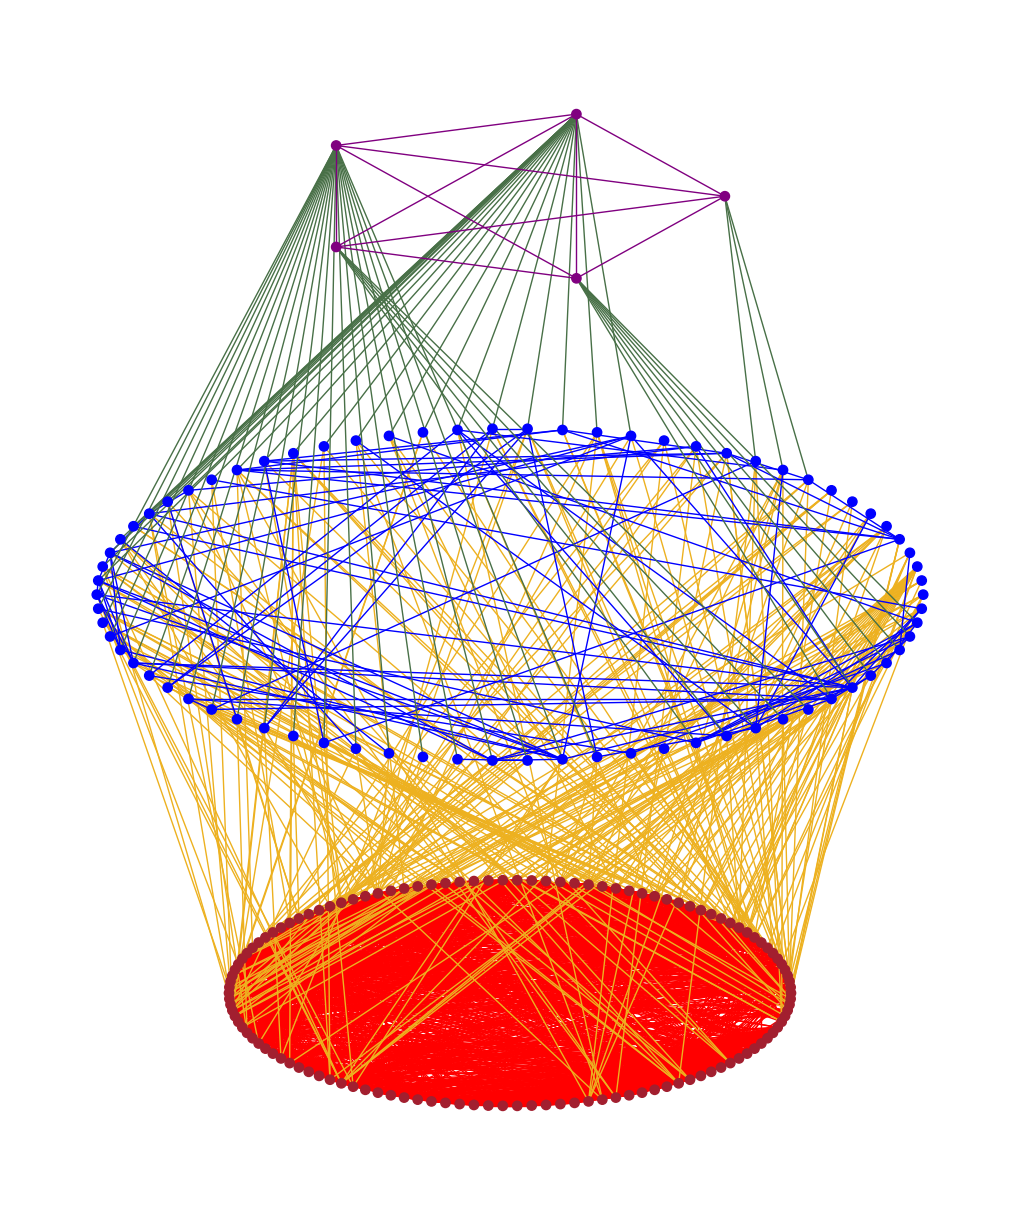

In [23]:
# Layers have coordinates and colors
layers = [
    (nx.Graph(), (0, 0), "#a21f2f"), # the lowest layer
    (nx.Graph(), (0, 1), "b"),
    (nx.Graph(), (0, 2), "purple")   # the highest layer
]
import itertools

# node ranges in the graph
# author, paper, venue
ranges = [(0,len1),(len1,len2),(len2,len3)]

# fill the layers with nodes from the graph
# prepare the color map
color_map = []
for (layer, coord, color), (start, end) in zip(layers, ranges):
    layer.add_nodes_from(itertools.islice(graph.nodes, start, end))
    color_map.extend([color for _ in range(start, end)])
    
# Calculate and move the nodes position
all_pos = {}
for layer, (sx, sy), color in layers:
    # pos = nx.circular_layout(layer, scale=2)  # or spring_layout...
    if (sx,sy) == (0,1):
        pos = nx.circular_layout(layer, scale=25)
    elif (sx,sy) == (0,2):
        pos = nx.circular_layout(layer, scale=13)
    else:
        pos = nx.circular_layout(layer, scale=17)
    for node in pos:
        all_pos[node] = pos[node]
        all_pos[node] += (60 * sx, 60 * sy)

# edge colors 
edges = graph.edges()
colors = [graph[u][v]['color'] for u,v in edges]
# Draw and display the graph
plt.figure(figsize=(10,12))
nx.draw(graph, all_pos, node_size=45, node_color=color_map,edge_color=colors,with_labels=False)

# plt.show(block=False)
plt.savefig('res/induen_aminer.pdf')
#   \author\paper\venue